<a href="https://colab.research.google.com/github/Actulus/IntelligensModszerekTantargy/blob/main/Mely_tanulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from google.colab import widgets

**Adatok betöltése és megjelenítése**

Ahogy az előadáson elhangzott, neurális hálózatokat különféle felismerési feladatokra használunk. Aktuális kutatási témák közé tartozik például a COVID korai diagnózisa röntgenfelvételek alapján, ld. pl.

https://www.sciencedirect.com/science/article/abs/pii/S0169260720314140

Ezen a gyakorlaton, annak érdekében, hogy gyorsan (1-2 perc alatt) tudjuk tanítani a neurális hálózatot, egy egyszerű felismerési feladattal foglalkozunk, kézzel írt számjegyek felismerésével, és számítások további gyorsítása érdekében az eredetileg 16x16 pixeles képeket átméretezzük 8x8 felbontású képekké.

In [3]:
data = np.loadtxt('https://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data')

In [4]:
original_img_size = (16, 16)
new_img_size = (8,8)

data_8x8 = []
for i in range(len(data)):
  img_16x16 = np.reshape(data[i,0:256], original_img_size)
  img_8x8 = cv2.resize(img_16x16, new_img_size)
  img_8x8 = np.reshape(img_8x8, (64))
  data_8x8.append( img_8x8 )

data_8x8 = np.array(data_8x8)

Néhány átméretezett képet megjelenítünk szürkeárnyalatos képként.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

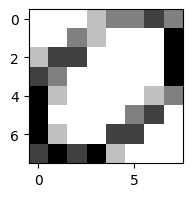

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

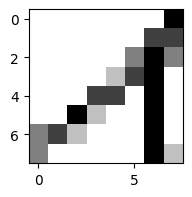

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

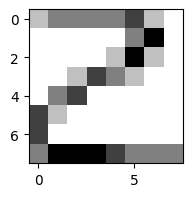

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

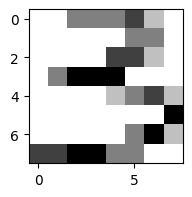

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

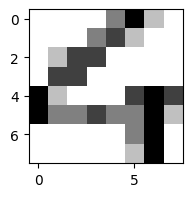

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

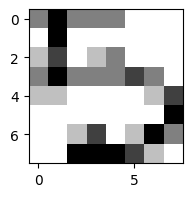

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

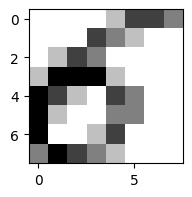

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

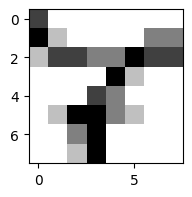

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

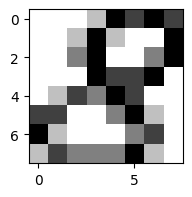

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

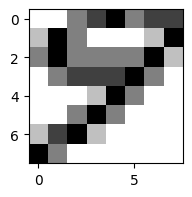

<IPython.core.display.Javascript object>

In [5]:
tb = widgets.TabBar([str(i) for i in range(10)], location='top')
for i in range(10):
  with tb.output_to(i):
    an_image = np.reshape(data_8x8[200+i*20], new_img_size )
    plt.figure(figsize=(2,2))
    plt.imshow(1-an_image, cmap='gray', vmin=0, vmax=1)
    plt.show()

Felosztjuk az adatainkat tanító és teszt adatokra. Az utolsó 500 példány lesz a teszt adathalmaz, a többi a tanítóhalmaz.

In [6]:
train_data = data_8x8[:1093,0:64]
train_labels = data[:1093,256:266]
test_data = data_8x8[1093:,0:64]
test_labels = data[1093:,256:266]

**A modell definiálása**

A köveketkezők feladatok során a most definiált neurális hálóból fogunk kiindulni. A bemeneti réteg unit-jainak száma 64, mert egy-egy kép 8x8=64 pixelt tartalmaz. A háló két belső réteggel rendelkezik, ezek 100 ill. 50 unitot tartalmaznak. A kimeneti rétegben a 10 osztály mindegyikének egy-egy unit felel meg. Definiálnunk kell a neurális háló által elvégzett számítást leíró forward(...) függvényt is.

In [7]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

**A háló tanítása:**
- a tanítóadatoból létrehozunk egy tensor datasetet, amelyet egy DataLoader-en keresztül fogunk elérni,
- példányosítjuk a hálót,
- megadjuk a célfüggvényt,
- példányosítjuk az optimalizáló algoritmust,
- végül a tanítóadatokon végighaladva az egyes batchekre elvégezzük az optimalizációs algoritmus egy-egy lépését (for ciklus)

In [8]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

**A háló pontosságának mérése**

Megnézzük, hogy a tesztpéldányok közül hányat sikerül helyesen osztályozni.

In [9]:
def eval_net(net):
  test_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(test_data), torch.Tensor(test_labels))
  testloader = torch.utils.data.DataLoader(test_dataset)

  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, targets in testloader:
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      _, targets_ordinal = torch.max(targets, 1)

      total += targets.size(0)
      correct += (predicted == targets_ordinal)

  return float(correct/total)

In [10]:
eval_net(net)

0.9020000100135803

**1. feladat: aktivációs függvények a rejtett rétegekben**

Az előbbi neurális hálóban cserélje ki az első és második rejtett rétegbeli aktivációs függvényt

(a) szigmoid (torch.sigmoid),

(b) softplus (torch.nn.functional.softplus),

(c) Leaky ReLU (torch.nn.functional.leaky_relu),

(d) Leaky ReLU 0.2-es negatív meredekséggel (negative_slope=0.2),

(e) tangens hiperbolicus (torch.tanh)

függvényre. Tanítsa és értékelje ki a hálózatot!

(a) szigmoid (torch.sigmoid)

In [11]:
# sigmoid
class DigitRecognizer2(nn.Module):
    def __init__(self):
        super(DigitRecognizer2, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.out(x)
        return x

In [12]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer2()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [13]:
eval_net(net)

0.28999999165534973

(b) softplus (torch.nn.functional.softplus)

In [14]:
# softplus
class DigitRecognizer3(nn.Module):
    def __init__(self):
        super(DigitRecognizer3, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10)

    def forward(self, x):
        x = torch.nn.functional.softplus(self.fc1(x))
        x = torch.nn.functional.softplus(self.fc2(x))
        x = self.out(x)
        return x

In [15]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [16]:
eval_net(net)

0.8999999761581421

(c) Leaky ReLU (torch.nn.functional.leaky_relu),



In [17]:
# leaky relu
class DigitRecognizer4(nn.Module):
    def __init__(self):
        super(DigitRecognizer4, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.out(x)
        return x

In [18]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer4()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [19]:
eval_net(net)

0.8980000019073486

(d) Leaky ReLU 0.2-es negatív meredekséggel (negative_slope=0.2),


In [20]:
# leaky relu with negative slope 0f 0.2
class DigitRecognizer5(nn.Module):
    def __init__(self):
        super(DigitRecognizer5, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.02)
        x = torch.nn.functional.leaky_relu(self.fc2(x), negative_slope=0.02)
        x = self.out(x)
        return x

In [21]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer5()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [22]:
eval_net(net)

0.9100000262260437

(e) tangens hiperbolicus (torch.tanh)

In [23]:
# tangent hyperbolic
class DigitRecognizer6(nn.Module):
    def __init__(self):
        super(DigitRecognizer6, self).__init__()
        num_units_h1 = 100
        num_units_h2 = 50

        self.fc1 = nn.Linear(64, num_units_h1)
        self.fc2 = nn.Linear(num_units_h1, num_units_h2)
        self.out = nn.Linear(num_units_h2, 10)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.out(x)
        return x

In [24]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer6()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [25]:
eval_net(net)

0.8859999775886536

**2. feladat: hibafüggvény**

A neurális háló tanítása során eredetileg kereszt-entrópiát ("binary cross entropy with logits loss") használtuk hibafüggvényként. Tanítsa a hálót a négyzetes hibák átlagát (nn.MSELoss) használva és értékelje ki a háló teljesítményét!

In [26]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [27]:
eval_net(net)

0.906000018119812

**3. feladat: optimalizáló algoritmus**

(a) A stochastic gradient descent és minibatch gradient descent algoritmusok egyik előnytelen tulajdonsága, hogy nem garantált, hogy az optimális irányba "lépünk" a paraméterek értékeinek frissítésekor. Sőt előfordulhat, hogy "össze-vissza" lépkedünk, egyszer a "jó" megoldás irányába, máskor egy masik irányba. Ezen próbál javítani a momentumok használata: momentumok használata esetén az aktuális javító lépés nem kizárólag az adott minibatch során számolt gradiensből adódik, hanem figyelembe vesszük a korábbi javítólépéseket is. Minél nagyobb a momentum értéke, annál többet számítanak a korábbi javítólépések, annál kevésbe fogunk "össze-vissza" ugrálni, azaz "egyenletesebben" haladunk a megoldás irányába. Paraméterezze az optimalizációs algoritmust úgy, hogy 0.2-es értékű momentumot használjon és értékelje ki a kapott hálót!

In [28]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.2)

running_loss = 0.0
running_n = 0

loss_history_02 = []

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

    loss_history_02.append(loss.item())

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [29]:
acc02 = eval_net(net)
acc02

0.9120000004768372

(b) Használjon 0.8-as értékű momentumot és hasonlítsa össze a kapott haló teljesítményét az előbbi hálóéval!

In [30]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.8)

running_loss = 0.0
running_n = 0

loss_history_08 = []

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

    loss_history_08.append(loss.item())

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [31]:
acc08 = eval_net(net)
acc08

0.921999990940094

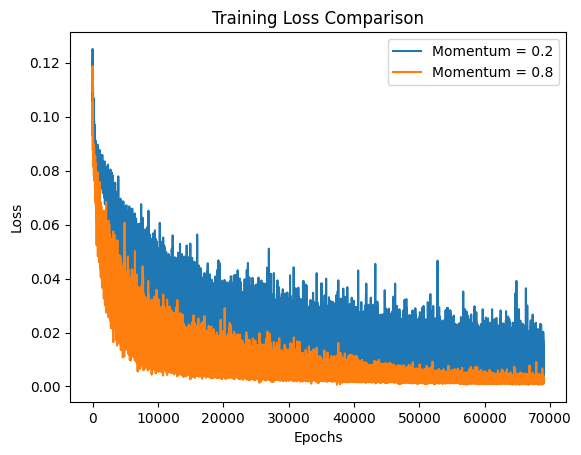

In [32]:
import matplotlib.pyplot as plt

plt.plot(loss_history_02, label="Momentum = 0.2")
plt.plot(loss_history_08, label="Momentum = 0.8")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()


(c) SGD helyett használja az ADAM (ADAptive Moments) optimalizációs algoritmust (optim.Adam)!

In [33]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

In [34]:
eval_net(net)

0.8059999942779541

**4. feladat: Tanulási ráta csökkentése**

Kezdetben, amíg "messze" vagyunk a "jó" megoldástól, érdemes lehet nagyobb tanulási rátát használni, részben azért, hogy gyorsan jussunk a "jó" megoldás közelébe, részeben pedig azért, hogy a hibafüggvény lokális minimumait "átugorjuk". (Lineáris regresszióval ellentétben a neurális hálók tanítása általában nem konvex otpimalizációs feladat.)

A torch.optim.lr_scheduler.StepLR-t használva csökkentse minden 10-dik epoch végén 10%-kal a tanulási rátát, a kezdeti tanulási rátát állítsa 0.05-re! Tanítsa majd értékelje ki a hálózatot! Ha szükséges, nézze tanulmányozza a dokumentációt: https://pytorch.org/docs/stable/optim.html

In [35]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

running_loss = 0.0
running_n = 0

loss_history = []

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

    loss_history.append(running_loss / running_n)

  scheduler.step()

  if (epoch + 1) % 50 == 0:
      print(f"Epoch {epoch+1}, Loss: {loss_history[-1]:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

  running_loss = 0.0
  running_n = 0

Epoch 50, Loss: 0.0107, LR: 0.029525
Epoch 100, Loss: 0.0069, LR: 0.017434
Epoch 150, Loss: 0.0054, LR: 0.010295
Epoch 200, Loss: 0.0048, LR: 0.006079
Epoch 250, Loss: 0.0044, LR: 0.003589
Epoch 300, Loss: 0.0042, LR: 0.002120
Epoch 350, Loss: 0.0041, LR: 0.001252
Epoch 400, Loss: 0.0041, LR: 0.000739
Epoch 450, Loss: 0.0040, LR: 0.000436
Epoch 500, Loss: 0.0040, LR: 0.000258
Epoch 550, Loss: 0.0040, LR: 0.000152
Epoch 600, Loss: 0.0040, LR: 0.000090
Epoch 650, Loss: 0.0040, LR: 0.000053
Epoch 700, Loss: 0.0040, LR: 0.000031
Epoch 750, Loss: 0.0040, LR: 0.000018
Epoch 800, Loss: 0.0040, LR: 0.000011
Epoch 850, Loss: 0.0040, LR: 0.000006
Epoch 900, Loss: 0.0040, LR: 0.000004
Epoch 950, Loss: 0.0040, LR: 0.000002
Epoch 1000, Loss: 0.0040, LR: 0.000001


In [36]:
test_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(test_data), torch.Tensor(test_labels)
)
testloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=16
)

correct = 0
total = 0

with torch.no_grad():  # No gradient computation during evaluation
    for inputs, targets in testloader:
        outputs = net(inputs)
        predicted = torch.argmax(outputs, dim=1)  # Get the class with highest score
        actual = torch.argmax(targets, dim=1)  # Assuming one-hot encoding
        correct += (predicted == actual).sum().item()
        total += targets.size(0)

accuracy = 100 * correct / total
print(f"Model accuracy: {accuracy:.2f}%")


Model accuracy: 91.20%


In [37]:
def evaluate_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            actual = torch.argmax(targets, dim=1)
            correct += (predicted == actual).sum().item()
            total += targets.size(0)
    return 100 * correct / total

accuracy = evaluate_model(net, testloader)
print(f"Final Model Accuracy: {accuracy:.2f}%")


Final Model Accuracy: 91.20%


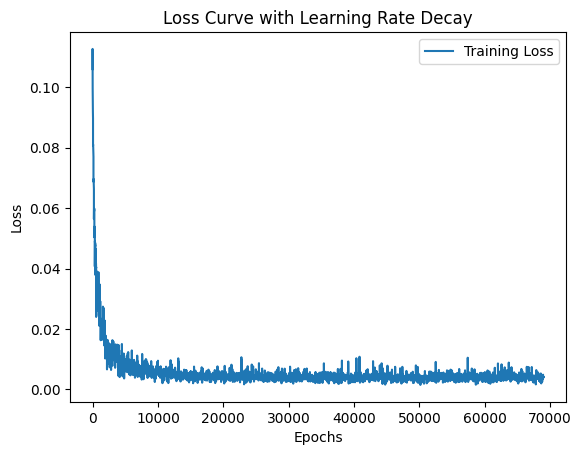

In [38]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve with Learning Rate Decay")
plt.legend()
plt.show()


**5. feladat: regularizáció**

(a) Early stop: minden tanítóepoch végén értékelje ki a neurális hálózatot, és határozza meg, hány epochig érdemes tanítani a legjobb pontosság eléréséhez. Az epoch végén végzett kiértékelés eredménye a hálózat tényleges pontosságának torzítatlan becslése lesz-e?




In [39]:
# Dataset & Dataloader
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_data), torch.Tensor(train_labels))
trainloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=16)

# Model, loss, optimizer
net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Early stopping variables
patience = 20  # Stop if no improvement in 20 epochs
best_loss = float("inf")
epochs_no_improve = 0
best_model = None  # Store best model

for epoch in range(1000):
    net.train()
    running_loss = 0.0
    running_n = 0

    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_n += 1

    avg_loss = running_loss / running_n  # Track overall loss

    # **Early Stopping Check**
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
        best_model = net.state_dict()  # Save best model
    else:
        epochs_no_improve += 1

    scheduler.step()

    # Print every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    # **Stop training if no improvement**
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best loss: {best_loss:.4f}")
        break

# Restore best model
net.load_state_dict(best_model)
print("Training completed with early stopping!")

Epoch 50, Loss: 0.0255, LR: 0.029525
Epoch 100, Loss: 0.0118, LR: 0.017434
Epoch 150, Loss: 0.0076, LR: 0.010295
Epoch 200, Loss: 0.0059, LR: 0.006079
Epoch 250, Loss: 0.0052, LR: 0.003589
Epoch 300, Loss: 0.0048, LR: 0.002120
Epoch 350, Loss: 0.0046, LR: 0.001252
Epoch 400, Loss: 0.0045, LR: 0.000739
Epoch 450, Loss: 0.0044, LR: 0.000436
Epoch 500, Loss: 0.0044, LR: 0.000258
Early stopping at epoch 520. Best loss: 0.0044
Training completed with early stopping!



(b) Az optimalizációs algoritmus paraméterezésével valósítson meg L2 regularizációt (az előadáson használt jelölések szerint) lambda=0.01 súllyal (Pytorch-ban "lambda" elnevezése: "weight_decay").

In [40]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, weight_decay=0.01)

running_loss = 0.0
running_n = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

  #print('epoch %d, loss: %.3f' % (epoch + 1, running_loss / running_n))
  running_loss = 0.0
  running_n = 0

eval_net(net)

0.07999999821186066

(c) Dropout (nn.Dropout) réteg bevezetésével valósítson meg dropout-ot a második rejtett réteget követően!

In [41]:
class DigitRecognizer7(nn.Module):
    def __init__(self):
        super(DigitRecognizer7, self).__init__()
        number_of_units_in_the_first_hidden_layer = 100
        number_of_units_in_the_second_hidden_layer = 50

        self.fc1 = nn.Linear(64, number_of_units_in_the_first_hidden_layer)
        self.fc2 = nn.Linear(number_of_units_in_the_first_hidden_layer, number_of_units_in_the_second_hidden_layer)

        self.dropout = nn.Dropout(p=0.5)  # Dropout added (50% probability)

        self.out = nn.Linear(number_of_units_in_the_second_hidden_layer, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after second hidden layer
        x = self.out(x)
        return x


In [42]:
# Load dataset
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_data), torch.Tensor(train_labels))
trainloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=16)

# Initialize model, loss, and optimizer
net = DigitRecognizer7()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, weight_decay=0.01)  # L2 regularization added

# Training loop
for epoch in range(1000):
    net.train()  # Set model to training mode
    running_loss = 0.0
    running_n = 0

    for inputs, targets in trainloader:
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_n += 1

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {running_loss / running_n:.4f}")

Epoch 50, Loss: 0.3433
Epoch 100, Loss: 0.3397
Epoch 150, Loss: 0.3371
Epoch 200, Loss: 0.3361
Epoch 250, Loss: 0.3360
Epoch 300, Loss: 0.3367
Epoch 350, Loss: 0.3351
Epoch 400, Loss: 0.3350
Epoch 450, Loss: 0.3348
Epoch 500, Loss: 0.3347
Epoch 550, Loss: 0.3348
Epoch 600, Loss: 0.3355
Epoch 650, Loss: 0.3344
Epoch 700, Loss: 0.3343
Epoch 750, Loss: 0.3354
Epoch 800, Loss: 0.3342
Epoch 850, Loss: 0.3353
Epoch 900, Loss: 0.3344
Epoch 950, Loss: 0.3347
Epoch 1000, Loss: 0.3346


In [43]:
# Evaluation function
def eval_net(model, dataloader):
    model.eval()  # Set model to evaluation mode (disables dropout)
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predictions = torch.round(torch.sigmoid(outputs))  # Convert logits to binary
            correct += (predictions == targets).sum().item()
            total += targets.numel()

    accuracy = correct / total * 100
    print(f"Validation Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate model
eval_net(net, trainloader)

Validation Accuracy: 90.00%


90.0

**6. feladat: Mély Neurális Hálózatok**

Definiáljon egy modellt, amelynek 4 rejtett rétege van, minden rejtett rétegben 100 unit legyen. Tanítsa a modellt és értékelje ki a modell pontosságát!


In [44]:
class DeepDigitRecognizer(nn.Module):
    def __init__(self):
        super(DeepDigitRecognizer, self).__init__()

        # 4 hidden layers with 100 units each
        self.fc1 = nn.Linear(64, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)

        self.out = nn.Linear(100, 10)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.out(x)  # No activation (for classification with BCEWithLogitsLoss)
        return x

In [45]:
# Load dataset
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_data), torch.Tensor(train_labels))
trainloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=16)

# Initialize model, loss function, and optimizer
net = DeepDigitRecognizer()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.8, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

for epoch in range(1000):
    net.train()  # Set to training mode
    running_loss = 0.0
    running_n = 0

    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_n += 1

    scheduler.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {running_loss / running_n:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    running_loss = 0.0
    running_n = 0


Epoch 50, Loss: 0.3266, LR: 0.029525
Epoch 100, Loss: 0.3263, LR: 0.017434
Epoch 150, Loss: 0.3263, LR: 0.010295
Epoch 200, Loss: 0.3259, LR: 0.006079
Epoch 250, Loss: 0.3259, LR: 0.003589
Epoch 300, Loss: 0.3258, LR: 0.002120
Epoch 350, Loss: 0.3260, LR: 0.001252
Epoch 400, Loss: 0.3256, LR: 0.000739
Epoch 450, Loss: 0.3259, LR: 0.000436
Epoch 500, Loss: 0.3258, LR: 0.000258
Epoch 550, Loss: 0.3258, LR: 0.000152
Epoch 600, Loss: 0.3258, LR: 0.000090
Epoch 650, Loss: 0.3258, LR: 0.000053
Epoch 700, Loss: 0.3259, LR: 0.000031
Epoch 750, Loss: 0.3257, LR: 0.000018
Epoch 800, Loss: 0.3257, LR: 0.000011
Epoch 850, Loss: 0.3257, LR: 0.000006
Epoch 900, Loss: 0.3257, LR: 0.000004
Epoch 950, Loss: 0.3257, LR: 0.000002
Epoch 1000, Loss: 0.3257, LR: 0.000001


In [46]:
def evaluate_accuracy(model, dataloader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predictions = torch.round(torch.sigmoid(outputs))  # Convert logits to binary (0 or 1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

    accuracy = correct / total * 100
    return accuracy

# Compute accuracy
train_acc = evaluate_accuracy(net, trainloader)

print(f"Training Accuracy: {train_acc:.2f}%")


Training Accuracy: 90.00%


**7. feladat: Konvolúciós hálózatok**

Adott az alábbi konvolúciós neurális hálózat. Tanulmányozza a kódot, majd hajtsa végre az alábbi módosításokat. Mindegyik módosítás után  tanítsa és értékelje ki a hálót!

In [50]:
class DigitRecognizerCNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerCNN, self).__init__()
        num_units_fc = 25

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 5,
                               kernel_size=(3,3))
        self.fc = nn.Linear(5*6*6, num_units_fc)
        self.out = nn.Linear(num_units_fc, 10)

    def forward(self, x):
        x = x.view(-1, 1, 8, 8)
        x = self.conv1(x)
        x = x.view(-1, 5*6*6)
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x

In [51]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizerCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

running_loss = 0.0
running_n = 0

best_acc = 0
best_epoch = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

In [53]:
def eval_net(net):
  test_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(test_data), torch.Tensor(test_labels))
  testloader = torch.utils.data.DataLoader(test_dataset)

  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, targets in testloader:
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      _, targets_ordinal = torch.max(targets, 1)

      total += targets.size(0)
      correct += (predicted == targets_ordinal)

  return float(correct/total)

eval_net(net)

0.9160000085830688

(a) Mennyi most a konvolúciós szűrők (más néven: *filterek*, vagy a konvolúció műveletének *kimeneti csatornáinak* száma)? Növelje meg a konvolúciós szűrők számát 10-re! 5

In [56]:
class DigitRecognizerCNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerCNN, self).__init__()
        num_units_fc = 25

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10,
                               kernel_size=(3,3))
        self.fc = nn.Linear(10*6*6, num_units_fc)
        self.out = nn.Linear(num_units_fc, 10)

    def forward(self, x):
        x = x.view(-1, 1, 8, 8)
        x = self.conv1(x)
        x = x.view(-1, 10*6*6)
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x

In [57]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizerCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

running_loss = 0.0
running_n = 0

best_acc = 0
best_epoch = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

eval_net(net)

0.9139999747276306

(b) Milyen méretű lokális mintázat felismerésére képes egy-egy konvolúciós szűrő? Növelje meg a kernel méretét 5x5-ösre!

In [66]:
class DigitRecognizerCNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerCNN, self).__init__()
        num_units_fc = 25

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10,
                               kernel_size=(5,5))
        self.fc = nn.Linear(10*4*4, num_units_fc)
        self.out = nn.Linear(num_units_fc, 10)

    def forward(self, x):
        x = x.view(-1, 1, 8, 8)
        x = self.conv1(x)
        x = x.view(-1, 10*4*4)
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x

# output = (input_size - kernel_size + 2 * padding) / stride + 1 -> 8-5+2*0/1+1 = 4

In [67]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizerCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

running_loss = 0.0
running_n = 0

best_acc = 0
best_epoch = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

eval_net(net)

0.8960000276565552

(c) Töltse fel a kép szélét nullákkal olyan módon, hogy a kép felbontása ne változzon a konvolúció során! (Tipp: *padding* állítása)

In [76]:
class DigitRecognizerCNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerCNN, self).__init__()
        num_units_fc = 25

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10,
                               kernel_size=(5,5), padding=2)
        self.fc = nn.Linear(10*8*8, num_units_fc)
        self.out = nn.Linear(num_units_fc, 10)

    def forward(self, x):
        x = x.view(-1, 1, 8, 8)
        x = self.conv1(x)
        x = x.view(-1, 10*8*8)
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x

In [77]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizerCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

running_loss = 0.0
running_n = 0

best_acc = 0
best_epoch = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

eval_net(net)

0.9079999923706055

(d) A konvolúciót követően vezessen be egy 2x2-es max pooling réteget! (Tipp: használja az *nn.MaxPool2d*-t!)

In [82]:
class DigitRecognizerCNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerCNN, self).__init__()
        num_units_fc = 25

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10,
                               kernel_size=(5,5), padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(10*4*4, num_units_fc)
        self.out = nn.Linear(num_units_fc, 10)

    def forward(self, x):
        x = x.view(-1, 1, 8, 8)
        x = self.conv1(x)
        x = self.pool(x)
        x = x.view(-1, 10*4*4)
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x

In [83]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizerCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

running_loss = 0.0
running_n = 0

best_acc = 0
best_epoch = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

eval_net(net)

0.9259999990463257

(e) A gyorsabb tanítás érdekében helyettesítse a max pooling réteget azzal, hogy a konvolúció lépéstávolságát 1-ről 2-re növeli! (Tipp: *stride* állítása)

In [86]:
class DigitRecognizerCNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerCNN, self).__init__()
        num_units_fc = 25

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(5,5), padding=2, stride=2)
        self.fc = nn.Linear(10*4*4, num_units_fc)
        self.out = nn.Linear(num_units_fc, 10)

    def forward(self, x):
        x = x.view(-1, 1, 8, 8)
        x = self.conv1(x)
        x = x.view(-1, 10*4*4)
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x



In [87]:
train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data), torch.Tensor(train_labels) )
trainloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=16)

net = DigitRecognizerCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

running_loss = 0.0
running_n = 0

best_acc = 0
best_epoch = 0

for epoch in range(1000):
  for inputs, targets in trainloader:
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_n = running_n + 1

eval_net(net)

0.9139999747276306

**Ajánlott irodalom**

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html